# Adapt-Recursive QAOA

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [11]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [12]:
def run_Rqaoa_experiment(qubo, rqaoa_type, n_max, n_steps):  
    
    # Define the RQAOA object (default rqaoa_type = 'adaptive')
    R = RQAOA()

    # Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
    #R.set_rqaoa_parameters(steps = 1, n_cutoff=3)
    if rqaoa_type == "custom":
        R.set_rqaoa_parameters(n_cutoff = 3, steps = n_steps, rqaoa_type = rqaoa_type)
    elif rqaoa_type == "adaptive":
        R.set_rqaoa_parameters(n_cutoff = 3, n_max = n_max, rqaoa_type = rqaoa_type)

    ## Setting up the QAOA properties

    # Set the properties you want - These values are actually the default ones!
    R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    # R.set_circuit_properties(p=1, init_type='custom', variational_params_dict={"betas":[0.01], "gammas":[0.01]}, mixer_hamiltonian='x')
 
    
    # Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
    device = create_device(location='local', name='vectorized')
    R.set_device(device)

    # Set the classical method used to optimiza over QAOA angles and its properties
    R.set_classical_optimizer(method="cobyla", 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-6), maxfev=6000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=True, 
                              cost_progress=True, parameter_log=True)

    # Here are other ways in which the above selection can be generalized!

    # device = create_device(location = 'qcs',name = 'Aspen-11', as_qvm = True, client_configuraton = qcs_credentials)
    # r.set_device(device)
    # r.set_backend_properties(n_shots=100, cvar_alpha=1)
    # r.set_circuit_properties(param_type = 'extended', init_type = 'fourier_extended')
    # r.set_classical_optimizer(method='Nelder-Mead', maxiter=1000)
    

    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    return R.results


In [13]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, betas, gammas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

In [14]:
def plot_landscape(cost_landscape, betas, gammas, sigma, mu):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    #plt.savefig("cost_landscape_sigma={}_mu={}.png".format(sigma, mu))
    plt.show()
    

In [ ]:
# Define problem

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 


rqaoa_type_list = ["custom", "adaptive"]

n_steps_list = [3]

seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

#seed_list = [1, 2]

data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)
        # Solve the problem analytically
        energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for rqaoa_type in rqaoa_type_list:
            print("rqaoa method type =", rqaoa_type)
            
            for n_steps in n_steps_list:
                n_max = n_steps
                print("number of steps =", n_steps)

            
                opt_results = run_Rqaoa_experiment(maxcut_qubo, rqaoa_type, n_max, n_steps)

                optimization_energy = list(opt_results['solution'].values())[0]
                
                optimization_schedule = list(opt_results['schedule'])

                # Obtain approximation ratio
                r = np.abs(optimization_energy) / np.abs(energy)

                data.append([sigma, seed, rqaoa_type, n_steps, n_max, r, optimization_schedule])

df = pd.DataFrame(np.array(data), columns=['sigma', 'seed', 'rqaoa_type', 'n_steps', 'n_max', 'r', 'optimization_schedule'])

df['sigma'] = df['sigma'].astype(float)
df['rqaoa_type'] = df['rqaoa_type'].astype(str)
df['seed'] = df['seed'].astype(int)
df['n_steps'] = df['n_steps'].astype(int)
df['n_max'] = df['n_max'].astype(int)
df['r'] = df['r'].astype(float)
#df['optimization_schedule'] = df['optimization_schedule'].astype(list)

Sigma = 0.1
Seed = 1
rqaoa method type = custom
number of steps = 3


/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


rqaoa method type = adaptive
number of steps = 3
Seed = 2
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 3
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 4
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 5
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 6
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 7
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 8
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 9
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed = 10
rqaoa method type = custom
number of steps = 3
rqaoa method type = adaptive
number of steps = 3
Seed 

In [28]:
df

,sigma,seed,rqaoa_type,n_steps,n_max,r,optimization_schedule
0,0.1,1,custom,3,3,1.000000,"[3, 3, 3]"
1,0.1,1,adaptive,3,3,1.000000,"[2, 2, 2, 2, 1]"
2,0.1,2,custom,3,3,1.000000,"[3, 3, 3]"
3,0.1,2,adaptive,3,3,1.000000,"[2, 2, 1, 1, 1, 1, 1]"
4,0.1,3,custom,3,3,0.867507,"[3, 3, 3]"
...,...,...,...,...,...,...,...
795,100.0,98,adaptive,3,3,0.660253,"[1, 2, 2, 1, 1, 1, 1]"
796,100.0,99,custom,3,3,0.529489,"[3, 3, 3]"
797,100.0,99,adaptive,3,3,0.771710,"[2, 2, 1, 2, 1, 1]"
798,100.0,100,custom,3,3,0.883900,"[3, 3, 3]"


In [29]:
#df.to_csv("data_23.11_RQAOA_type_n_steps=3.csv")

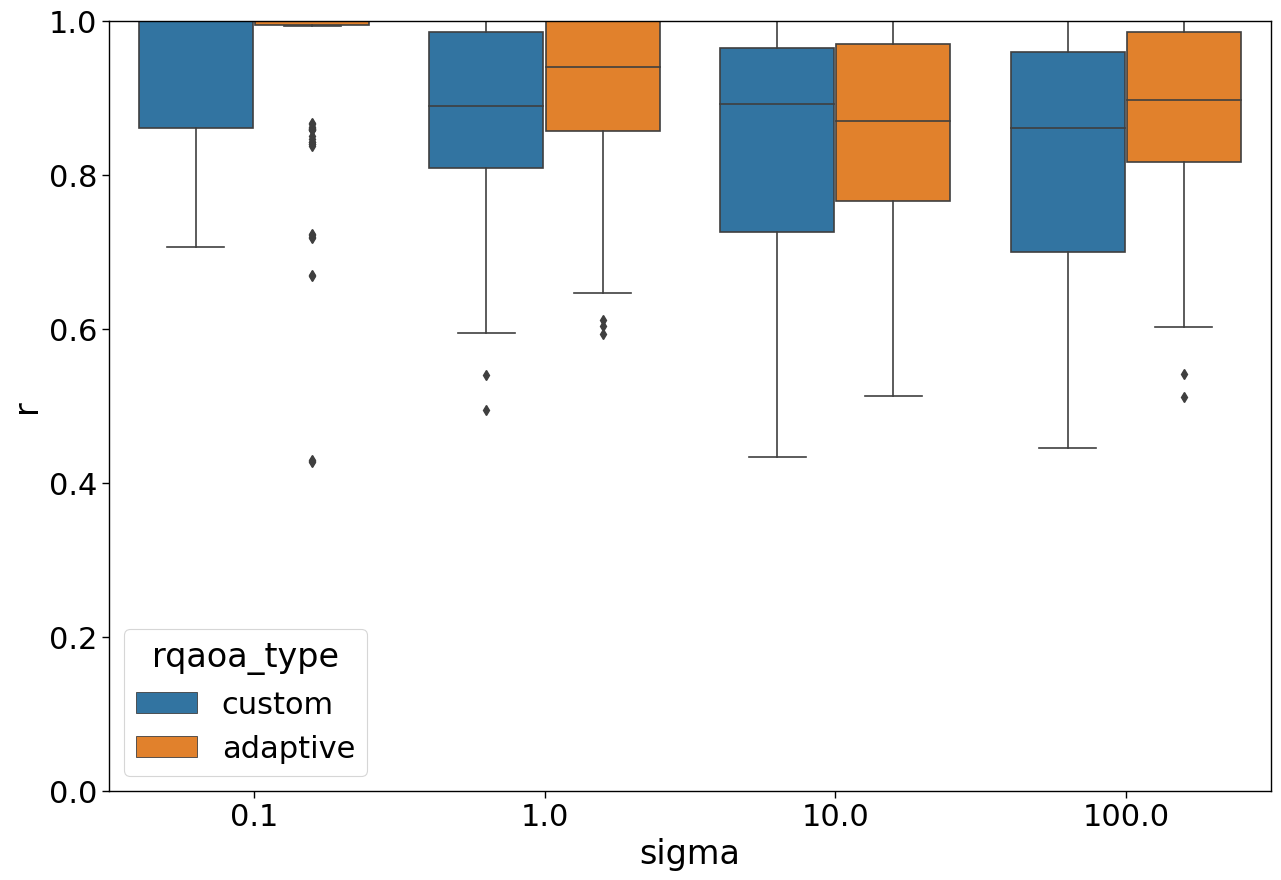

In [30]:
#plt.xscale('log')
plt.ylim(0, 1)
box_plot = sns.boxplot(data = df, x = 'sigma', y ='r', hue="rqaoa_type")

plt.savefig("RQAOA_type_n_steps=3.png")


In [15]:
df

,sigma,seed,rqaoa_type,n_steps,n_max,r
0,0.1,1,custom,1,2,1.000000
1,0.1,1,adaptive,1,2,1.000000
2,0.1,2,custom,1,2,1.000000
3,0.1,2,adaptive,1,2,0.852573
4,0.1,3,custom,1,2,1.000000
...,...,...,...,...,...,...
75,100.0,8,adaptive,1,2,0.897200
76,100.0,9,custom,1,2,1.000000
77,100.0,9,adaptive,1,2,1.000000
78,100.0,10,custom,1,2,0.802050


In [17]:
df.to_csv("data_18.11_RQAOA_type_n_steps=1.csv")

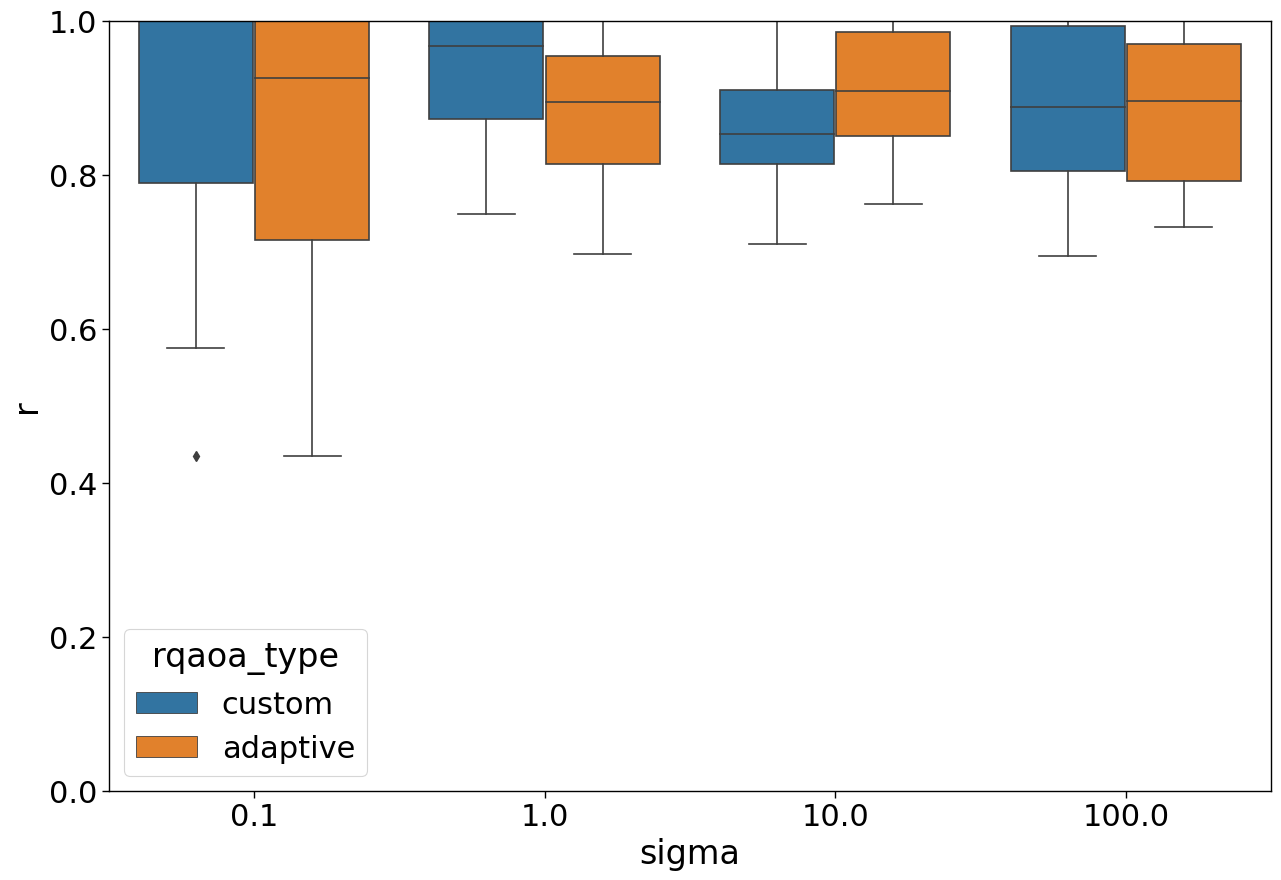

In [18]:
#plt.xscale('log')
plt.ylim(0, 1)
box_plot = sns.boxplot(data = df, x = 'sigma', y ='r', hue="rqaoa_type")

plt.savefig("r_RQAOA_type_n_steps=1.png")
